[View in Colaboratory](https://colab.research.google.com/github/pirsquared/Colaboratory/blob/master/Obtain_%60min%60_and_%60idxmin%60_(or_%60max%60_and_%60idxmax%60)_at_the_same_time_(%E2%80%9Csimultaneously%E2%80%9D)%3F.ipynb)

# Imports

In [0]:
import pandas as pd
import numpy as np
from timeit import timeit

pd.set_option(
    'display.notebook_repr_html', False,
    'expand_frame_repr', False,
    'display.max_colwidth', 50
)
%matplotlib inline

# [Obtain `min` and `idxmin` (or `max` and `idxmax`) at the same time (“simultaneously”)?](https://stackoverflow.com/questions/51932428/obtain-min-and-idxmin-or-max-and-idxmax-at-the-same-time-simultaneou)

In [0]:
df = pd.DataFrame({
    'id': [0,1,2,3,4], 
    'option_1': [10,     np.nan, np.nan, 400,    600], 
    'option_2': [np.nan, 20,     300,    np.nan, 700], 
    'option_3': [np.nan, 200,    30,     np.nan, 50],
    'option_4': [110,    np.nan, np.nan, 40,     50], 
})

## Clever and Quick with `T` (transpose) and `agg`
As pointed out in the comments, Pandas 0.24 effectively allows an `axis=1` parameter with a list of functions with the `agg` method.

This answer is fashioned for brevity and not performance.

In [108]:
df.set_index('id').T.agg(['min', 'idxmin']).T

  min    idxmin
0  10  option_1
1  20  option_2
2  30  option_3
3  40  option_4
4  50  option_3

# Numpy v1

In [109]:
d_ = df.set_index('id')
v = d_.values
pd.DataFrame(dict(
    Min=np.nanmin(v, axis=1),
    Idxmin=d_.columns[np.nanargmin(v, axis=1)]
), d_.index)

      Idxmin   Min
id                
0   option_1  10.0
1   option_2  20.0
2   option_3  30.0
3   option_4  40.0
4   option_3  50.0

# Numpy v2

In [110]:
col_mask = df.columns.str.startswith('option')
options = df.columns[col_mask]
v = np.column_stack([*map(df.get, options)])
pd.DataFrame(dict(
    Min=np.nanmin(v, axis=1),
    IdxMin=options[np.nanargmin(v, axis=1)]
))

     IdxMin   Min
0  option_1  10.0
1  option_2  20.0
2  option_3  30.0
3  option_4  40.0
4  option_3  50.0

# Full simulation

In [0]:
def pir_agg_1(df):
  return df.set_index('id').T.agg(['min', 'idxmin']).T

def pir_agg_2(df):
  d_ = df.set_index('id')
  v = d_.values
  return pd.DataFrame(dict(
      Min=np.nanmin(v, axis=1),
      IdxMin=d_.columns[np.nanargmin(v, axis=1)]
  ))

def pir_agg_3(df):
  col_mask = df.columns.str.startswith('option')
  options = df.columns[col_mask]
  v = np.column_stack([*map(df.get, options)])
  return pd.DataFrame(dict(
      Min=np.nanmin(v, axis=1),
      IdxMin=options[np.nanargmin(v, axis=1)]
  ))

def wen_agg_1(df):
  v = df.filter(like='option')
  d = v.stack().sort_values().groupby(level=0).head(1).reset_index(level=1)
  d.columns = ['IdxMin', 'Min']
  return d

def tot_agg_1(df):
  """I combined toto_tico's 2 filter calls into one"""
  d = df.filter(like='option')
  return df.assign(
      IdxMin=d.idxmin(1),
      Min=d.min(1)
  )

def tot_agg_2(df):
  d = df.filter(like='option')
  idxmin = d.idxmin(1)
  return df.assign(
      IdxMin=idxmin,
      Min=d.lookup(d.index, idxmin)
  )

def sim_df(n, m):
  return pd.DataFrame(
      np.random.randint(m, size=(n, m))
  ).rename_axis('id').add_prefix('option').reset_index()

In [0]:
fs = 'pir_agg_1 pir_agg_2 pir_agg_3 wen_agg_1 tot_agg_1 tot_agg_2'.split()
ix = [10, 30, 100, 300, 1000, 3000, 10000]

res_small_col = pd.DataFrame(index=ix, columns=fs, dtype=float)
res_large_col = pd.DataFrame(index=ix, columns=fs, dtype=float)

for i in ix:
  df = sim_df(i, 10)
  for j in fs:
    stmt = f"{j}(df)"
    setp = f"from __main__ import {j}, df"
    res_small_col.at[i, j] = timeit(stmt, setp, number=10)
    
for i in ix:
  df = sim_df(i, 100)
  for j in fs:
    stmt = f"{j}(df)"
    setp = f"from __main__ import {j}, df"
    res_large_col.at[i, j] = timeit(stmt, setp, number=10)

In [102]:
res_small_col.div(res_small_col.min(1), 0)

         pir_agg_1  pir_agg_2  pir_agg_3  wen_agg_1  tot_agg_1  tot_agg_2
10       12.465358   1.272584        1.0   5.978435   2.168994   2.164858
30       26.538924   1.305721        1.0   5.331755   2.121342   2.193279
100      80.304708   1.277684        1.0   7.221127   2.215901   2.365835
300     230.009000   1.338177        1.0   5.869560   2.505447   2.576457
1000    661.432965   1.249847        1.0   8.931438   2.940030   3.002684
3000   1757.339186   1.349861        1.0  12.541915   4.656864   4.961188
10000  3342.701758   1.724972        1.0  15.287138   6.589233   6.782102

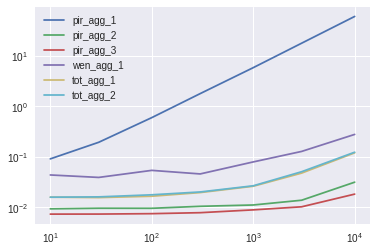

In [104]:
res_small_col.plot(loglog=True)

In [103]:
res_large_col.div(res_large_col.min(1), 0)

        pir_agg_1  pir_agg_2  pir_agg_3  wen_agg_1  tot_agg_1  tot_agg_2
10       8.008895   1.000000   1.977989   5.612195   1.727308   1.769866
30      18.798077   1.000000   1.855291   4.350982   1.618649   1.699162
100     56.725786   1.000000   1.877474   6.749006   1.780816   1.850991
300    132.306699   1.000000   1.535976   7.779359   1.707254   1.721859
1000   253.771648   1.000000   1.232238  12.224478   1.855549   1.639081
3000   346.999495   2.246106   1.000000  21.114310   1.893144   1.626650
10000  431.135940   2.095874   1.000000  32.588886   2.203617   1.793076

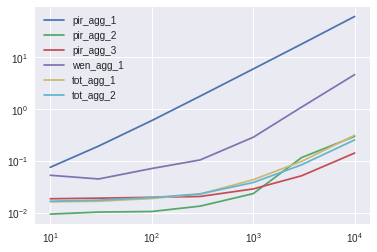

In [105]:
res_large_col.plot(loglog=True)